In [2]:
from keras.applications.efficientnet_v2 import EfficientNetV2B3
from keras.preprocessing import image
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil
import keras
import os

In [3]:
print(tf.__version__)

2.8.4


In [4]:
TARGET_SIZE = (540, 756) #half of original

In [5]:
MODEL_TRAIN = False
if MODEL_TRAIN:
    ds_train = tf.keras.utils.image_dataset_from_directory(
        'ds_train',
        labels='inferred',
        label_mode='binary',
        color_mode='rgb',
        batch_size=1,
        image_size=TARGET_SIZE,
        subset='training',
        seed=42,
        validation_split=0.2,
        interpolation='bilinear',
    )

    ds_valid = tf.keras.utils.image_dataset_from_directory(
        'ds_train',
        labels='inferred',
        label_mode='binary',
        color_mode='rgb',
        batch_size=1,
        image_size=TARGET_SIZE,
        subset='validation',
        seed=42,
        validation_split=0.2,
        interpolation='bilinear',
    )

    base_model = EfficientNetV2B3(
        weights='imagenet', include_top=False)
    base_model.trainable = False
    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
                  metrics=[
                      'accuracy',
                      tf.keras.metrics.AUC()
                  ])
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=1000,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            patience=3, restore_best_weights=True, monitor='val_loss')],
    )
    #     Epoch 50/1000
    # 724/724 [==============================] - 36s 50ms/step - loss: 0.0265 - accuracy: 0.9972 - auc: 0.9972 - val_loss: 0.0651 - val_accuracy: 0.9889 - val_auc: 0.9915
    model.save('cleaning_model.h5')
else:
    model = keras.models.load_model('cleaning_model.h5')


In [6]:
FOLDER_CLEANING = "deep/person"
img_paths = []
scores = []
for file in tqdm(os.listdir(FOLDER_CLEANING)):
    path = os.path.join(FOLDER_CLEANING, file)
    img = image.load_img(path, target_size=TARGET_SIZE, interpolation='bilinear')
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    img_paths.append(file)
    scores.append(pred[0][0])

100%|██████████| 1499/1499 [03:44<00:00,  6.67it/s]


<AxesSubplot: >

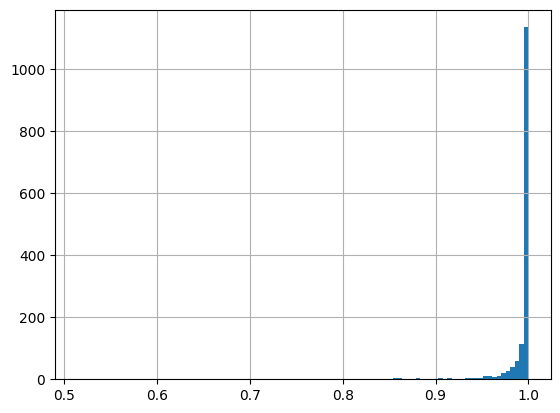

In [7]:
df = pd.DataFrame()
df['file'] = img_paths
df['score'] = scores
df.score.hist(bins=100)

In [8]:
THRESHOLD = 0.5

In [9]:
df[df.score < 0.9].shape, df[df.score < 0.5].shape, df[df.score < 0.1].shape

((39, 2), (0, 2), (0, 2))

In [10]:
FOLDER_MOVETO = "deep/suspicious"
MOVE = False
if MOVE:
    for a in tqdm(df[df.score < THRESHOLD].file):
        shutil.move(os.path.join(FOLDER_CLEANING, a), FOLDER_MOVETO)